# **Intro**

This is a simple NN cell-type proportion predictor.
This is a simple baseline that will be used to compare the M1, M2, and other models.


# **Imports**

In [1]:
# general imports
import warnings
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda, Flatten, Softmax, ReLU, ELU, LeakyReLU
from keras.layers.merge import concatenate as concat
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import backend as K
from tensorflow.keras.losses import mean_absolute_error, mean_squared_error, KLDivergence
from tensorflow.keras.datasets import mnist
from tensorflow.keras.activations import relu, linear
from tensorflow.keras.utils import to_categorical, normalize, plot_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, SGD
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix
from scipy.stats import spearmanr, pearsonr
from scipy.spatial.distance import euclidean
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score
from PIL import Image

from tqdm import tnrange, tqdm_notebook
import ipywidgets

# Images, plots, display, and visualization
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale

# programming stuff
import time
import os
import pickle
from pathlib import Path

# import the SC_preprocessing code
import sys
sys.path.insert(1, '../../')
sys.path.insert(1, '../')
from sc_preprocessing import sc_preprocess


# disable eager execution
# https://github.com/tensorflow/tensorflow/issues/47311#issuecomment-786116401
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()


In [2]:
## parameters
aug_data_path = f"{os.getcwd()}/../data/single_cell_data/augmented_pbmc_data/"
res_data_path = f"{os.getcwd()}/../results/single_cell_data/diva_pbmc/"
num_genes = 1000

exp_id = "pbmc6k-mono"

# Set-up experimental variables

In [3]:

##################################################
#####. set up experiment specific variables
##################################################

#if args.exp_id != "pbmc68k":
#    sys.exit("Error, exp_id not currently supported")
        
# number expected cell types
n_cell_types = 7

# number of patients/domains/samples expected
idx_range_lab = range(0, 10)
#idx_range_unlab = range(0, 10)
n_tot_samples = 10

# number of drugs (one-hot encoded)
n_drugs = 2

# experiment id
lab_file_name = exp_id
#unlab_file_name = args.unlab_exp_id

# number of pseudobulks PER patient
n_train = 1000



### create the domains label 
Label_full = np.concatenate([np.full(n_train, 0), np.full(n_train, 1),
                            np.full(n_train, 2), np.full(n_train, 3),
                            np.full(n_train, 4), np.full(n_train, 5),
                            np.full(n_train, 6), np.full(n_train, 7),
                            np.full(n_train, 8), np.full(n_train, 9)], axis=0)
label_full = to_categorical(Label_full)

### create the drugs label 
Drug_full = np.concatenate([np.full(n_train, 1), np.full(n_train, 0),
                            np.full(n_train, 0), np.full(n_train, 0),
                            np.full(n_train, 0), np.full(n_train, 1),
                            np.full(n_train, 1), np.full(n_train, 1),
                            np.full(n_train, 0), np.full(n_train, 0)], axis=0)
drug_full = to_categorical(Drug_full)

# indexes for the training
# 1-9 is labeled training
# 11-19 is unlabeled
# 10 is held out to test
# 0 is held out
#idx_train = np.where(np.logical_and(Label_full>0, Label_full!=3))[0]
#idx_unlab = np.where(Label_full == 3)[0]
#idx_0 = np.where(Label_full==0)[0]

idx_train = np.where(np.logical_and(Label_full > 0, Label_full < 5))[0]
idx_unlab = np.where(Label_full > 5)[0]
idx_drug = np.where(Drug_full > 0)[0]
idx_5 = np.where(Label_full == 5)[0]
idx_0 = np.where(Label_full==0)[0]

idx_train = np.where(np.logical_and(Label_full > -1, Label_full < 2))[0]
idx_unlab = np.where(Label_full >= 2)[0]
idx_drug = np.where(Drug_full > 0)[0]
idx_5 = np.where(Label_full == 5)[0]
idx_0 = np.where(Label_full==0)[0]



# **Load / Pre-process data**
Import pre-processed pseudobulks

In [4]:

##################################################
#####. Design the experiment
##################################################

# read in the labeled data
X_train, Y_train, gene_df = sc_preprocess.read_all_diva_files(aug_data_path, idx_range_lab, lab_file_name)
X_train.columns = gene_df

# only get genes that are available in both testing and training
common_genes_file = os.path.join(aug_data_path, "intersection_genes.pkl")
gene_out_path = Path(common_genes_file)
common_genes = pickle.load(open( gene_out_path, "rb" ))

# try using the cibersort genes
cibersort_file_path = f"{os.getcwd()}/../results/single_cell_data/cibersort_pbmc/CIBERSORTx_Job8_pbmc6k-mono_0_cybersort_sig_inferred_phenoclasses.CIBERSORTx_Job8_pbmc6k-mono_0_cybersort_sig_inferred_refsample.bm.K999.txt"
cibersort_df = pd.read_csv(cibersort_file_path, sep="\t" )
cibersort_genes = cibersort_df["NAME"].values.tolist()

common_genes = np.union1d(common_genes, cibersort_genes)
X_train = X_train[common_genes]
X_train.head()

gene_df = gene_df.loc[gene_df.isin(common_genes)]


# convert to data matrices
X_full = X_train.to_numpy()
Y_full = Y_train.to_numpy()

## get the top variable genes
X_colmean = X_full.mean(axis=0)
#X_colvar = X_full.var(axis=0)
#X_CoV = np.array(np.divide(X_colvar, X_colmean+0.001))
#idx_top = np.argpartition(X_CoV, -num_genes)[-num_genes:]
#gene_df = gene_df.iloc[idx_top]

X_full = X_train.loc[:,cibersort_genes]
X_full = X_full.to_numpy()

## normalize within sample
X_full = scale(X_full, axis=1)
            
print(X_full.shape)

print(np.where(X_colmean == 0)[0].tolist())



# for unknown proportions; i.e. 3 
X_unkp = X_full[idx_unlab,]
label_unkp = label_full[idx_unlab,]
drug_unkp = drug_full[idx_unlab,]
y_unkp = Y_full[idx_unlab,]

# for known proportions
X_kp = X_full[idx_train,]
label_kp = label_full[idx_train,]
drug_kp = drug_full[idx_train,]
y_kp = Y_full[idx_train,]


# test
X_0 = X_full[idx_0,]
label_0 = label_full[idx_0,]
drug_0 = drug_full[idx_0,]
y_0 = Y_full[idx_0,]


(10000, 1540)
[]


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.009s...
[t-SNE] Computed neighbors for 10000 samples in 3.694s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 3.701865
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.121284
[t-SNE] KL divergence after 300 iterations: 2.069602
(10000, 2)
(10000, 2)


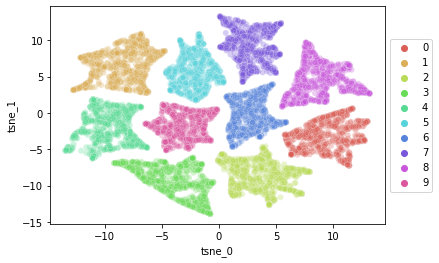

In [5]:
## plot samples
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(X_full)

plot_df = pd.DataFrame(tsne_results[:,0:2])
print(tsne_results.shape)
print(plot_df.shape)
plot_df.columns = ['tsne_0', 'tsne_1']
plot_df['augmentation'] = Label_full

g = sns.scatterplot(
    x="tsne_0", y="tsne_1",
    data=plot_df,
    hue="augmentation",
    palette=sns.color_palette("hls", n_tot_samples),
    legend="full",
    alpha=0.3
)
g.legend(loc='center left', bbox_to_anchor=(1, 0.5))


# **Model Definition**


## Hyperparameters

In [6]:

##################################################
#####. Hyperparameters
##################################################

batch_size = 500
n_epoch = 500 # 100 

alpha_rot = 1000000
#alpha_class = 100
alpha_prop = 100 #100
alpha_drug = 1000000

beta_kl_slack = 10
beta_kl_rot = 100
beta_kl_prop = 10
beta_kl_drug = 1000


n_x = X_full.shape[1]
n_y = Y_full.shape[1]
n_label = n_tot_samples  # 6 "patients" 1 sample augmented into 6 distinct versions
n_drugs = n_drugs  # number of drugs one-hot encoded
n_label_z = 64  # 64 dimensional representation of rotation


# the network dimensions are 784 > 512 > proportion_dim < 512 < 784
n_z = Y_full.shape[1] # latent space size, one latent dimension PER cell type
encoder_dim = 512 # dim of encoder hidden layer
decoder_dim = 512 # dim of encoder hidden layer
decoder_out_dim = n_x # dim of decoder output layer

# labeled classifier
class_dim1 = 32
class_dim2 = 16


activ = 'relu'
optim = Adam(learning_rate=0.001)

print(f"length of X {n_x} and length of y {n_y} n_label {n_label} and n_drugs {n_drugs}")

length of X 1540 and length of y 7 n_label 10 and n_drugs 2


## Classifier

In [7]:
# declare the Keras tensor we will use as input to the encoder
X = Input(shape=(n_x,))
Y = Input(shape=(n_y,))
label = Input(shape=(n_label,))
props = Input(shape=(n_y,))
z_in = Input(shape=(n_y+n_label_z+n_label_z,))
cls_in = Input(shape=(n_label_z,))

inputs = X

# set up labeled classifier
class_hidden1 = Dense(class_dim1, activation=activ, name = "cls_h1")
class_hidden2 = Dense(class_dim2, activation=activ, name="cls_h2")
class_out = Dense(n_y, activation='softmax', name="cls_out")

classifier_h1 = class_hidden1(inputs)
classifier_h2 = class_hidden2(classifier_h1)
Y_cls = class_out(classifier_h2)




## Loss

In [8]:
def class_loss(y_true, y_pred):
    recon = K.sum(mean_absolute_error(y_true, y_pred), axis=-1)*alpha_rot
    return recon




## Make the computational graph

In [9]:


# M2 Model

classifier = Model(X, Y_cls)

print(classifier.summary())


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1540)]            0         
_________________________________________________________________
cls_h1 (Dense)               (None, 32)                49312     
_________________________________________________________________
cls_h2 (Dense)               (None, 16)                528       
_________________________________________________________________
cls_out (Dense)              (None, 7)                 119       
Total params: 49,959
Trainable params: 49,959
Non-trainable params: 0
_________________________________________________________________
None


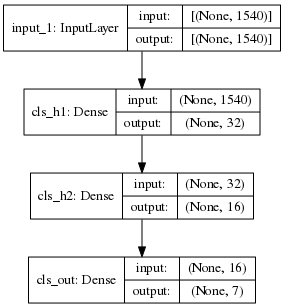

In [10]:
display(plot_model(classifier, show_layer_names=True, show_shapes=True, dpi=72))

Now train

In [11]:
# helper methods for evaluation
def sum_abs_error(y_pred, y_true):
  return sum(abs(y_pred - y_true))

def mean_abs_error(y_pred, y_true):
  return np.mean(abs(y_pred - y_true))

def mean_sqr_error(y_pred, y_true):
  return np.mean((y_pred - y_true)**2)

def get_errors(y_true, y_est):
  mse_err = [mean_sqr_error(y_true[idx], y_est[idx]) 
                  for idx in range(0, y_est.shape[0])]

  print(f"MSqE mean: {np.mean(mse_err)}, median: {np.median(mse_err)}, max: {max(mse_err)}")

  spr_err = [spearmanr(y_true[idx].astype(float), y_est[idx].astype(float))[0]
                    for idx in range(0, y_est.shape[0])]
  print(f"Spearman mean: {np.mean(spr_err)}, median: {np.median(spr_err)}, max: {max(spr_err)}")

  pear_err = [pearsonr(y_true[idx].astype(float), y_est[idx].astype(float))[0]
                    for idx in range(0, y_est.shape[0])]
  print(f"Pearson mean: {np.mean(pear_err)}, median: {np.median(pear_err)}, max: {max(pear_err)}")

  error_list = [mse_err, spr_err, pear_err]
  plot_df = [item for sublist in error_list for item in sublist]
  plot_df = pd.DataFrame(plot_df)
  plot_df.columns = ["error"]
  plot_df["error_type"] = ["MSQ"]*y_est.shape[0] + ["SPR"]*y_est.shape[0] + ["PEAR"]*y_est.shape[0]

  return plot_df


In [12]:
classifier.compile(optimizer = Adam(learning_rate=0.001), loss=class_loss, metrics=['accuracy'])                                



In [13]:
classifier.fit(X_kp, y_kp, epochs=1000)

Train on 2000 samples
Epoch 1/1000


2023-01-10 17:40:26.723556: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


2000/2000 [==============================] - 0s 163us/sample - loss: 3169495.2630 - accuracy: 0.5695
Epoch 2/1000
2000/2000 [==============================] - 0s 38us/sample - loss: 1868813.2755 - accuracy: 0.8340
Epoch 3/1000
2000/2000 [==============================] - 0s 37us/sample - loss: 1513989.1470 - accuracy: 0.8780
Epoch 4/1000
2000/2000 [==============================] - 0s 38us/sample - loss: 1370250.6790 - accuracy: 0.8995
Epoch 5/1000
2000/2000 [==============================] - 0s 37us/sample - loss: 1278483.7335 - accuracy: 0.9040
Epoch 6/1000
2000/2000 [==============================] - 0s 36us/sample - loss: 1241958.2635 - accuracy: 0.9130
Epoch 7/1000
2000/2000 [==============================] - 0s 36us/sample - loss: 1181269.6255 - accuracy: 0.9225
Epoch 8/1000
2000/2000 [==============================] - 0s 36us/sample - loss: 1153668.9220 - accuracy: 0.9200
Epoch 9/1000
2000/2000 [==============================] - 0s 36us/sample - loss: 1101723.4960 - accuracy: 0.

In [14]:
def plot_cell_specific_corr(xval, yval, ax, title, xlab, ylab, class_id):

    plot_df = pd.DataFrame(list(zip(xval, yval)))
    plot_df.columns = [xlab, ylab]

    g = sns.scatterplot(
        x=xlab, y=ylab,
        data=plot_df,ax=ax,
        hue=class_id
    )
    g.set(ylim=(0, 1))
    g.set(xlim=(0, 1))
    g.plot([0, 1], [0, 1], transform=g.transAxes)

    ax.set_title(title)
    return g

/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


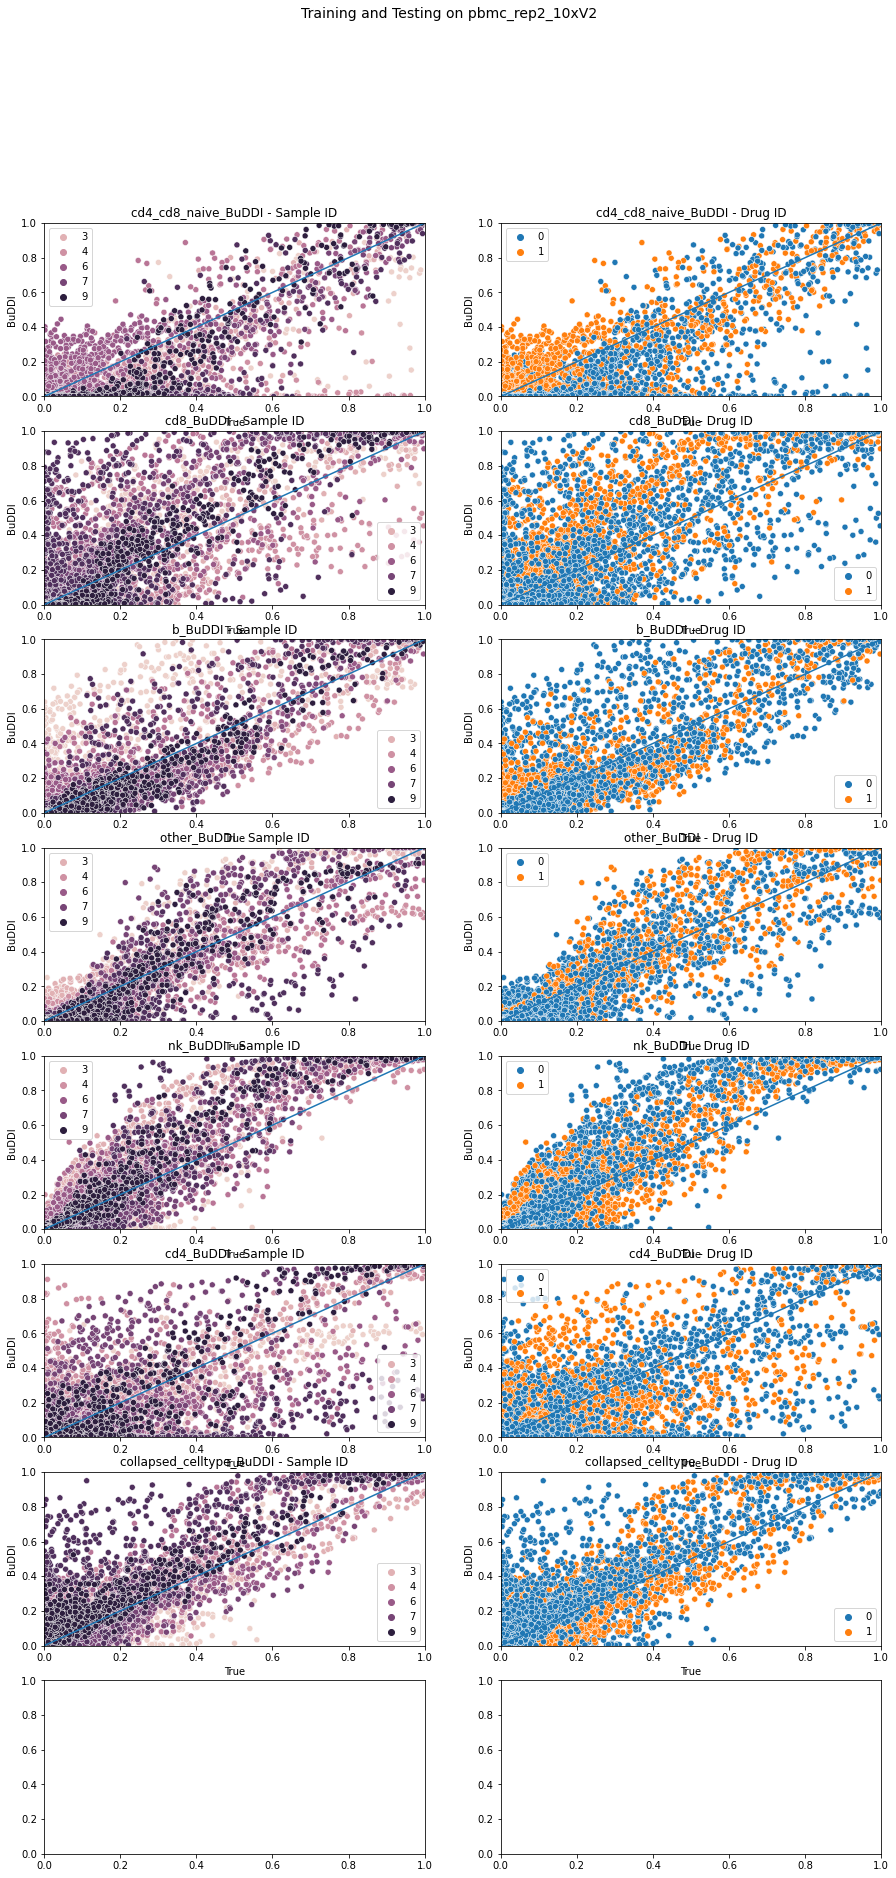

In [15]:
# make predictions
prop_outputs = classifier.predict(X_unkp, batch_size=batch_size)

## plot for the unlabeled

prop_df = pd.DataFrame(prop_outputs, columns=Y_train.columns)
true_prop_df = Y_train.iloc[idx_unlab]

fig, axs = plt.subplots(8, 2, figsize=(15,30))
row_idx = 0
for curr_cell in true_prop_df.columns:

    plot_cell_specific_corr(true_prop_df[curr_cell], prop_df[curr_cell], axs[row_idx,0], title=f"{curr_cell}_BuDDI - Sample ID", xlab="True", ylab="BuDDI", class_id=Label_full[idx_unlab])
    plot_cell_specific_corr(true_prop_df[curr_cell], prop_df[curr_cell], axs[row_idx,1], title=f"{curr_cell}_BuDDI - Drug ID", xlab="True", ylab="BuDDI", class_id=Drug_full[idx_unlab])
    row_idx = row_idx +1


fig.suptitle("Training and Testing on pbmc_rep2_10xV2", fontsize=14)

fig.show()

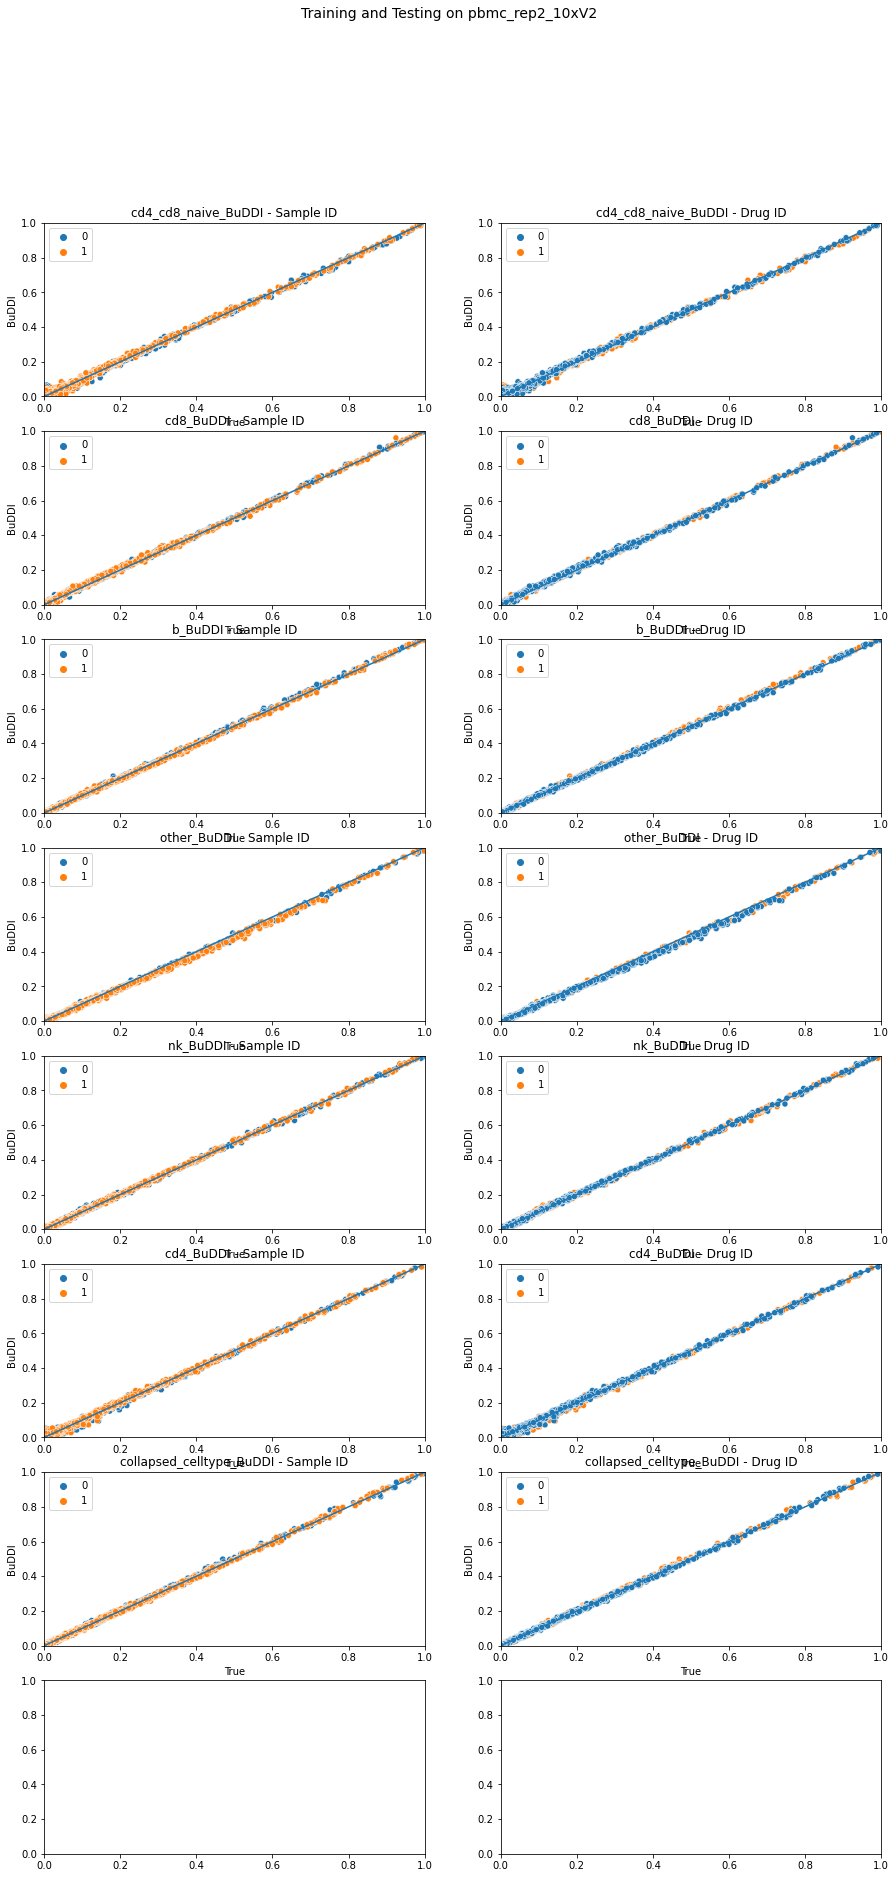

In [16]:
# make predictions
prop_outputs = classifier.predict(X_kp, batch_size=batch_size)


## plot for the labeled

prop_df = pd.DataFrame(prop_outputs, columns=Y_train.columns)
true_prop_df = Y_train.iloc[idx_train]

fig, axs = plt.subplots(8, 2, figsize=(15,30))
row_idx = 0
for curr_cell in true_prop_df.columns:

    plot_cell_specific_corr(true_prop_df[curr_cell], prop_df[curr_cell], axs[row_idx,0], title=f"{curr_cell}_BuDDI - Sample ID", xlab="True", ylab="BuDDI", class_id=Label_full[idx_train])
    plot_cell_specific_corr(true_prop_df[curr_cell], prop_df[curr_cell], axs[row_idx,1], title=f"{curr_cell}_BuDDI - Drug ID", xlab="True", ylab="BuDDI", class_id=Drug_full[idx_train])
    row_idx = row_idx +1


fig.suptitle("Training and Testing on pbmc_rep2_10xV2", fontsize=14)

fig.show()